In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pwd
%cd /content/drive/MyDrive/LSTM project/LSTM_Project/sector_analysis(food drug)/2016-2019(before covid)

/content
/content/drive/MyDrive/LSTM project/LSTM_Project/sector_analysis(food drug)/2016-2019(before covid)


In [3]:
# sector-> Food & Drug store(2016/01/01~2019/12/31) 
import pandas as pd
df1=pd.read_csv("SVNDY.csv") 
df2=pd.read_csv("WBA.csv")  
df3=pd.read_csv("MTRAF.csv")
df4=pd.read_csv("COOP.csv") 
df5=pd.read_csv("JSAIY.csv")  
df6=pd.read_csv("ADRNY.csv")  
df7=pd.read_csv("TSCDY.csv")  
df8=pd.read_csv("KR.csv")    
df9=pd.read_csv("AGHC.csv")  
df10=pd.read_csv("CRRFY.csv") 
df11=pd.read_csv("WNGRF.csv") 

print(df1.shape, df2.shape, df3.shape, df4.shape, df5.shape, df6.shape, df7.shape, df8.shape, df9.shape, df10.shape, df11.shape)
df1

(1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8) (1006, 8)


,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2016-01-04,22.240000,22.809999,22.230000,22.790001,22.790001,385800
1,1,2016-01-05,22.610001,22.750000,22.480000,22.670000,22.670000,52600
2,2,2016-01-06,22.370001,22.520000,22.209999,22.389999,22.389999,66000
3,3,2016-01-07,22.350000,22.629999,22.150000,22.629999,22.629999,49900
4,4,2016-01-08,21.690001,22.030001,21.510000,21.570000,21.570000,69000
...,...,...,...,...,...,...,...,...
1001,1001,2019-12-24,18.150000,18.430000,18.150000,18.379999,18.379999,29000
1002,1002,2019-12-26,18.280001,18.370001,18.280001,18.299999,18.299999,50500
1003,1003,2019-12-27,18.690001,18.690001,18.280001,18.389999,18.389999,55100
1004,1004,2019-12-30,17.940001,18.290001,17.940001,18.230000,18.230000,70900


# Make models (train)

In [4]:
from keras.layers import *
def make_models(c, nl, v, V=False, output_c=['High'], output_i=[2], outputs_company=1, train_size=754, time_step=60, epochs=30, units=50): 
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping
  """
  items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}
  v=[1, 2, 3, 4, 6]  
  output_c=['High']
  output_i=[2] 　"""
  
  print(f"[Arguments]") 
  print(f"num_company={len(nl)}社 {nl}")
  print(f"input_item={v}, outout_item={output_i}, output_category={output_c}")
  print(f"train_size={train_size}, time_step={time_step}, num_epoch={epochs}, num_units(neurons)={units}")
  print("")

  print("~~Make models~~")
  #1. split train and test data
  train_data=[]
  test_data=[]
  for i in range(len(c)):
    train_data.append(c[i].iloc[: train_size, v].values)
    test_data.append(c[i].iloc[train_size:, v].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  #2. train_data->normalise depending on number of inputs (only the volume is processed separately as the scale is different)
  #3. make X_train, y_train flexibly
  X_train=[]
  y_trains=[]
  
  if len(output_i) != 1:
    print("SECTOR1")
    # print(f"output>=2, inputs={v}, outputs={output_c}")
    training_set_others=np.hstack((data[:,:-1] for data in train_data))
    training_set_volume=np.hstack((data[:,-1:].reshape(-1, 1) for data in train_data))

    ss_others=[]
    for i in range(training_set_others.shape[1]):
      ss1=StandardScaler()
      ss_others.append(ss1.fit_transform(training_set_others[:,i].reshape(-1, 1)))
    ss_others=np.hstack(ss_others)

    ss2=StandardScaler()
    ss_v=ss2.fit_transform(training_set_volume)
    concat=np.hstack((ss_others, ss_v))
    # print(f"concat={concat.shape}")

    #ind=output用のvariablesのindexを抜き取る=>個別に学習モデルを作成するため
    if 6 in output_i: 
      print("SECTOR1-1")
      ind = []
      for i in range(len(output_i)):
        if output_i[i] != 6:
          ind+=[j for j in range(v.index(output_i[i]), len(c)*(len(v)-1), len(v)-1)] 
        else:
          ind+=[k for k in range(len(c)*(len(v)-1), len(c)*len(v))]
                              
      # print(f"len(ind)={len(ind)}, ind={ind}")
      for l in range(time_step, train_size):
        X_train.append(concat[l-time_step: l, :])
        for m in range(len(ind)):
          y_trains.append(concat[l, ind[m]])
      print(len(X_train), len(y_trains))

    else:
      print("SECTOR1-2")
      ind=[]
      for i in range(len(output_i)):
        ind+=[j for j in range(v.index(output_i[i]), len(c)*(len(v)), len(v))] 
      # print(f"num_of_companies={len(c)}, ind={ind}")
      
      for l in range(time_step, train_size):
        X_train.append(concat[l-time_step: l, :])
        for m in range(len(ind)):
          y_trains.append(concat[l, ind[m]])
      print(len(X_train), len(y_trains))

  else: #outputが１つの時
    print("SECTOR2")
    if V:
      print("SECTOR2-1")

      training_set_volume=np.hstack((data[:,-1].reshape(-1, 1) for data in train_data))
      ss2=StandardScaler()
      ss_v=ss2.fit_transform(training_set_volume)

      # print(f"concat={ss_v.shape}")

      ind = [id for id in range(len(c))]
      # print(f"num_of_companies={len(c)}, ind={ind}")

      for j in range(time_step, train_size):
        X_train.append(ss_v[j-time_step: j, :])
        for k in range(len(ind)):
          y_trains.append(ss_v[j, ind[k]])

    else: # volume含まれていない時
      print("SECTOR2-2")
      # from sklearn.preprocessing import MinMaxScaler#確認用
      # ss３=MinMaxScaler(feature_range=(0,1))

      training_set_all=np.hstack(np.array(train_data))
      ss2=StandardScaler()

      concat=ss2.fit_transform(training_set_all)

      ind = [id for id in range(len(c))]

      for j in range(time_step, train_size):
        X_train.append(concat[j-time_step: j, :])
        for k in range(len(ind)):
          y_trains.append(concat[j, ind[k]])

  X_train=np.array(X_train)
  y_trains=np.array(y_trains)
  print(f"X_train={X_train.shape}, y_trains={y_trains.shape}")
  # print("finish making X_train and y_trains")
  #3.train models(numbers of companies)

  y_trains2=[]
  
  if len(output_i) != 1:
    for x in range(len(c)*len(output_i)):
      x_tr=np.array([y_trains[i] for i in range(x, len(y_trains), len(c)*len(output_i))])
      y_trains2.append(x_tr)

  else: # len(output_i)==1
    for y in range(len(c)):
      y_tr=np.array([y_trains[i] for i in range(y, len(y_trains), len(c))])
      y_trains2.append(y_tr)

  y_trains2=np.array(y_trains2)
  print(f"y_trains2={y_trains2.shape}")

  model_lists = []
  
  for l in range(outputs_company):
    print(f"{l+1}/{outputs_company}")

    model = Sequential()

    model.add(LSTM(units = units, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2] )))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = False))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    model.fit(X_train, y_trains2[l], epochs=epochs, batch_size=32)
    model_lists.append(model)
    print("")
  return model_lists, y_trains2[:outputs_company]

# Make predictions (test)


In [5]:
# Make predictions
def make_preds(c, nl, v, model_lists, y_trains2, V=False, output_c=['High'], output_i=[2], train_size=754, time_step=60):
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping
  
  print("~~Make predctions~~")
  #4. Prepare test data and normalise and make predictions
  train_data=[]
  test_data=[]
  for i in range(len(c)):
    train_data.append(c[i].iloc[: train_size, v].values)
    test_data.append(c[i].iloc[train_size:, v].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  inputs = []
  
  for m in range(len(c)): # ここではvで指定したvariablesだけのarrayに加工している
    inputs.append(c[m].iloc[:, v][len(c[m])-len(test_data[m])-time_step:].values)
  
  inputs = np.array(inputs)
  variables=[]
  ss=[]
  for i in range(len(c)):
    for j in range(len(v)): #11*5=55
      m=inputs[i, :, j].reshape(-1, 1) 
      s=StandardScaler()
      t=s.fit_transform(m)

      variables.append(t)
      ss.append(s)
  
  inputs2=np.hstack(variables)
  s1=StandardScaler()
  inputs2=s1.fit_transform(inputs2)
  
  X_test = []
  # use all components as imputs for testing
  for n in range(time_step, np.array(test_data).shape[1]+time_step):
    X_test.append(inputs2[n-time_step:n, :])

  X_test = np.array(X_test)
  preds = [] #(11, 252) (252, 1)
  for o in range(len(y_trains2)):
    preds.append(np.array(model_lists[o].predict(X_test)))
  
  if len(output_i)==1:
    ind=[i for i in range(v.index(output_i[0]), len(c)*len(v), len(v))]
  else:
    ind=[]
    for i in range(len(output_i)):
      ind+=[j for j in range(v.index(output_i[i]), len(c)*len(v), len(v))]

  for p in range(len(y_trains2)): #(252, 11)
    preds[p] = ss[ind[p]].inverse_transform(preds[p]) #修正必要
  preds = np.array(preds)

  #5. Plot actual vs preds
  # df ={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6] 
  actual_lists_test=[]
  actual_lists_train=[]
  for dd in range(len(output_i)):
    # for cc in range(len(c)):
    actual_lists_test+=[sc.iloc[train_size:,output_i[dd]] for sc in c]
    actual_lists_train+=[sc.iloc[:train_size,output_i[dd]] for sc in c]
  
  if len(output_i) > 1:
    R2=nl*len(output_i) # lists of companies
  else: R2=nl
  
  print(f"actual_lists_train={np.array(actual_lists_train).shape}, actual_lists_test={np.array(actual_lists_test).shape}, preds_list={np.array(preds).shape}")

  R=0
  r=[r for r in range(len(c)-1, len(R2), len(c))]
  print(f"[{output_c}]")
  
  plt.figure(figsize=(18, 27))
  for p in range(len(R2)):
    plt.subplot(4, 2, p+1) 
    plt.plot(c[0].loc[:train_size-1,'Date'], actual_lists_train[p], color='black', label='Real(Trainning)')
    plt.plot(c[0].loc[train_size:,'Date'], actual_lists_test[p], color='red', label='Real(Test)')
    plt.plot(c[0].loc[train_size:,'Date'], preds[p], color='blue', label='Predict')
    plt.xticks(np.arange(0, 1006, 251))
    plt.xlabel('Date')
    plt.ylabel('High Price($)')
    
    from sklearn.metrics import r2_score
    plt.title(f"R2: {R2[p]}={round(r2_score(actual_lists_test[p], preds[p].flatten()), 4)}")

    R +=r2_score(actual_lists_test[p], preds[p].flatten())
    plt.legend()
  plt.show()

  if p in r:
    print(f"R2-{len(c)}companies_average={round(R/len(c), 4)}")
    R=0
    print("")

  #6. Make confusion matrix

  # columns = nl # labeling 
  # Actual 
  # print("Actual")
  # act=[a for a in actual_lists]
  # Actual=pd.concat(act, axis=1)
  # Actual.columns = columns
  # plt.figure(figsize=(12, 10))
  # cmap=sns.diverging_palette(220, 20, as_cmap=True)
  # sns.heatmap(Actual.corr(method='spearman'), cmap=cmap, annot=True) 

  # Predictions
  # for p in range(len(output_i)):
  #   print(f"Preds_Heatmap={output_c[p]} correlation")
  #   prd=[preds[p] for p in range(len(c)*p, len(c)+p*len(c))]
  #   # print(len(prd))
  #   Preds= pd.DataFrame(np.concatenate(prd, axis=1))
  #   Preds.columns = columns
  #   # print(Preds.columns)
  #   plt.figure(figsize=(8, 6))
  #   cmap=sns.diverging_palette(220, 20, as_cmap=True)
  #   sns.heatmap(Preds.corr(method='spearman'), cmap=cmap, annot=True) 

  # return preds[p].flatten()

  """Metro can be a special case, but the ohter companies in the same sector would have a sort of similarity. """

# 6月22日以降　


## ALL in ALL Function

In [6]:
all_data=[df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}
import random

def all_in_all(original_all_data, num_company=11, input_num=[2], output_category=['High'], output_num=[2], outputs_company=11, 
               train_size=754, time_step=60, epochs=20, units=50):

  all_companies_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)',
    "Royal Ahold Delhaize(Netherlands)", "Tesco(Britain)", "Kroger(USA)", "AEON(Japan)", "Carrefour(France)", "George Weston(Canada)"]

  # Pick up companies rondomly
  company_list=random.sample(all_companies_list, num_company) 
  
  all_data=[]
  for d in range(num_company):
    ind = all_companies_list.index(company_list[d])
    all_data.append(original_all_data[ind])

  if 6 not in input_num: Volume=False
  else: Volume=True

  # Make Models
  model_lists, y_trains = make_models(all_data, company_list, input_num, Volume, output_category, 
                                      output_num, outputs_company, train_size, time_step, epochs, units)
  # Make Predictions               
  make_preds(all_data, company_list, input_num, model_lists, y_trains, Volume, output_category, output_num, train_size, time_step)

In [13]:
# データ集計 Box Plot作成
#  num_company=2
# R2_2_lists=['ST', 'MA', 'JC', 'KG', 'CM', 'WK', 'MK', 'SCo', 'MJ' ,'TM']
# R2_2=[(0.9501, 0.6941), (0.9545, 0.8508), (0.8968, 0.9454), (0.9087, 0.929), (0.8993, 0.9245), (0.9681, 09435), (0.955, 0.9494), (0.9676, 0.9316), (0.935, 0.7436), (0.53, 0.971)]
R2=[0.8221, 0.9051, 0.9211, 0.9188, 0.9119, 0.9558, 0.9522, 0.9461, 0.8393, 0.7505]

#  num_company=3
# R2_3_lists=['JCG', 'CKR', 'KWC', 'SKJ', 'WSJ', 'WRT', 'SJW', 'RCG', 'RKM', 'AKS']
# R2_3=[(0.6291, 0.6584, 0.8378), (0.6354, 0.7489, 0.6679), (0.8528, 0.4896, 0.5124), (0.723, 0.828, 0.0878), (0.7512, 0.8263, -0.0773),
#       (0.5695, 0.3843, 0.7165), (0.5468, 0.6334, 0.9461), (0.6645, 0.8923, 0.8081), (0.5921, 0.925, 0.8236), (0.3229, 0.7187, 0.8993)]
R3=[0.7204, 0.6841, 0.6183, 0.5463, 0.5001, 0.5568, 0.7088, 0.7883, 0.7802, 0.6469]

# num_company=4
# R2_4_lists=['CoMJG', 'TRAG', 'KWCJ', 'TCoGA', 'STGR', 'GKMC', 'MGKS', 'RCoMG', 'RTJS', 'GSWJ']
# R2_4=[(0.4577, 0.8141, 0.122, 0.7028), (0.3441, 0.6427, -0.8182, 0.6032), (0.5235, 0.3445, 0.36, 0.6078), (0.3326, 0.5766, 0.7115, -0.4384), (0.6527, 0.1325, 0.0343, 0.6474), (0.585, 0.5378, 0.6607 ,0.0652),
#       (0.6727, 0.5174, 0.4982, 0.5175), (0.49, 0.6023, 0.7765, 0.8766), (0.5826, 0.3921, -0.2044, 0.4396), (0.6399, 0.6628, 0.6049, 0.0095)]
R4=[0.5242, 0.193, 0.4589, 0.2956, 0.3667, 0.4637, 0.5515, 0.6864, 0.3025, 0.4793]

# num_company=5
# R2_5_lists=['STWACo', 'GASKR', 'ATJMW', 'MGJAW', 'SRWCK', 'TSCoAK', 'MWGKR', 'KTMRJ', 'RASWJ', 'GKRSCo']
# R2_5=[(0.7645, 0.3403, 0.4466, 0.1759, 0.2708), (0.0959, 0.2261, 0.3582, 0.6539, 0.3361), (0.6624, 0.2059, -0.0847, 0.3093, 0.0466), (0.0642, 0.6875, 0.519, 0.3177, 0.3282), (0.0115, 0.6688, 0.6388, 0.0878, 0.4988), (0.2565, 0.1914, 0.5771, -0.1367, 0.7547), 
#       (0.1612, 0.1884, 0.5813, 0.6518, 0.2321), (0.4333, 0.0864, 0.2209, 0.414, 0.0521), (0.6111, 0.2379, 0.2044, 0.5652, 0.2097), (0.5032, 0.6804, 0.3805, 0.2962, 0.3294)]
R5=[0.3996, 0.3341, 0.1455, 0.3843, 0.3811, 0.3291, 0.363, 0.2414, 0.3657, 0.4379]

# num_company=6
# R2_6_lists=['GCMTWK', 'GKCoRWM', 'TWRJGK', 'CoASTWM', 'STCoWRK', 'ATCJMG', 'GAKTWJ', 'MGTCoCW', 'KJSMTC', 'MCoTRCA']
# R2_6=[(0.6879, 0.1381, 0.1541, 0.0378, 0.1057, 0.5592), (0.6926, 0.6478, 0.1272, 0.4308, 0.6335, 0.4336), (0.2605, 0.3501, 0.7276, 0.1003, 0.4526, 0.6673), (0.3881, 0.3013. 0.6094, 0.0616, 0.4148, 0.1898), (0.2889, 0.3481, 0.2046, 0.3273, 0.5591, 0.6136),
#       (-0.6971, 0.1829, 0.4009, 0.379, -0.4355, 0.6469), (0.6537, 0.5288, 0.5873, 0.3369, 0.4863, -0.2221), (0.1894, 0.5324, -0.0413, -0.0899, 0.2939, -0.1743), (0.2966, 0.5684, 0.5882, 0.4752, 0.3308, 0.171), (0.1925, 0.3633, 0.2466, 0.6581, 0.3865, 0.3157)]
R6=[0.2805, 0.4924, 0.4264, 0.3275, 0.3902, 0.08, 0.3952, 0.1184, 0.4049, 0.3604]

# num_company=7
# R2_7_lists=['CWMKRJCo', 'MKGJWRT', 'KCoASGWM', 'KASRGJT', 'RASMCGK', 'TRGKMWS', 'MKRSACoW', 'RCoJMCTA', 'RAGSWJC', 'CoSJMWGA']
# R2_7=[(-0.3276, 0.3932, 0.2361, 0.5213, 0.5768, 0.6053, 0.0431), (0.1081, 0.585, 0.2744, 0.0928, 0.2247, 0.6595, 0.2477), (0.6654, 0.4927, -0.1244, 0.256, 0.3975, 0.3289, 0.3574), (0.5765, -0.1861, 0.4102, 0.7029, 0.4211, 0.0781, 0.2816), (0.5839, -0.2264, 0.5432, 0.0262, 0.026, 0.5871, 0.4322),
#       (0.2801, 0.549, 0.3936, 0.704, -0.0267, 0.2489, 0.3151), (0.3883, 0.624, 0.633, 0.5042, 0.3508, 0.2109, 0.2716), (0.5359, 0.037, 0.5925, -0.0481, 0.4726, 0.3151, -0.3096), (0.5182, -0.1958, 0.4945, 0.491, -0.0161, 0.0895, 0.0284), (0.258, 0.7025, 0.6672, 0.17, 0.1315, 0.3437, 0.2438)]
R7=[0.2926, 0.3132, .3391, 0.3263, 0.2817, 0.352, 0.4261, 0.2279, 0.2014, 0.2899]

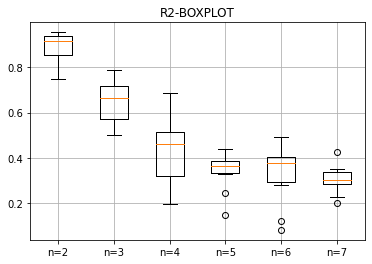

In [16]:
import matplotlib.pyplot as plt

R2_scores=(R2, R3, R4, R5, R6, R7)
fix, ax = plt.subplots()
boxplots = ax.boxplot(R2_scores)
ax.set_xticklabels(['n=2', 'n=3', 'n=4', 'n=5', 'n=6', 'n=7'])
plt.title('R2-BOXPLOT')
plt.grid()
plt.show()

## 流れ
### 1. Randomで会社を選定
### 2. Trainningデータも同時に表示
### 3. Subprot表示に対応(4✖︎2構成)

# N=2~7 Box Plot 作成用 *10

[Arguments]
num_company=2社 ['Seven & I Holdings (Japan)', 'Tesco(Britain)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 13s 220ms/step - loss: 0.6407
Epoch 2/50
22/22 [==============================] - 5s 218ms/step - loss: 0.3788
Epoch 3/50
22/22 [==============================] - 5s 218ms/step - loss: 0.3557
Epoch 4/50
22/22 [==============================] - 5s 219ms/step - loss: 0.3347
Epoch 5/50
22/22 [==============================] - 5s 214ms/step - loss: 0.2953
Epoch 6/50
22/22 [==============================] - 5s 219ms/step - loss: 0.2632
Epoch 7/50
22/22 [==============================] - 5s 218ms/step - loss: 0.2381
Epoch 8/50
22/22 [==============================] - 5s 221ms/step - loss: 0.2306
Epoch 9

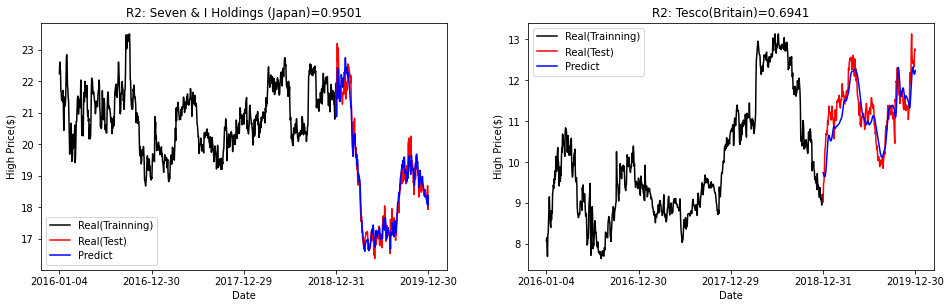

R2-2companies_average=0.8221091373730683

[Arguments]
num_company=2社 ['Metro (Canada)', 'AEON(Japan)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 13s 220ms/step - loss: 0.5336
Epoch 2/50
22/22 [==============================] - 5s 219ms/step - loss: 0.2373
Epoch 3/50
22/22 [==============================] - 5s 217ms/step - loss: 0.2119
Epoch 4/50
22/22 [==============================] - 5s 217ms/step - loss: 0.1538
Epoch 5/50
22/22 [==============================] - 5s 219ms/step - loss: 0.1632
Epoch 6/50
22/22 [==============================] - 5s 219ms/step - loss: 0.1439
Epoch 7/50
22/22 [==============================] - 5s 218ms/step - loss: 0.1350
Epoch 8/50
22/22 [==============================] - 5s 219ms/

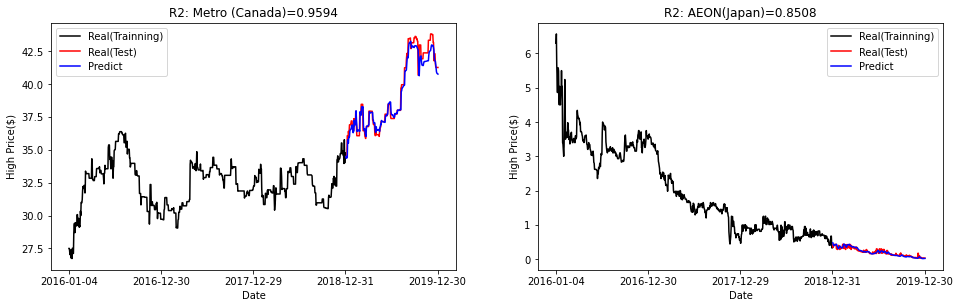

R2-2companies_average=0.9051014969213196

[Arguments]
num_company=2社 ['J.Sainsbury(Britain)', 'Carrefour(France)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 12s 219ms/step - loss: 0.5880
Epoch 2/50
22/22 [==============================] - 5s 215ms/step - loss: 0.1575
Epoch 3/50
22/22 [==============================] - 5s 219ms/step - loss: 0.1388
Epoch 4/50
22/22 [==============================] - 5s 216ms/step - loss: 0.1190
Epoch 5/50
22/22 [==============================] - 5s 217ms/step - loss: 0.1199
Epoch 6/50
22/22 [==============================] - 5s 220ms/step - loss: 0.1048
Epoch 7/50
22/22 [==============================] - 5s 223ms/step - loss: 0.0969
Epoch 8/50
22/22 [==============================]

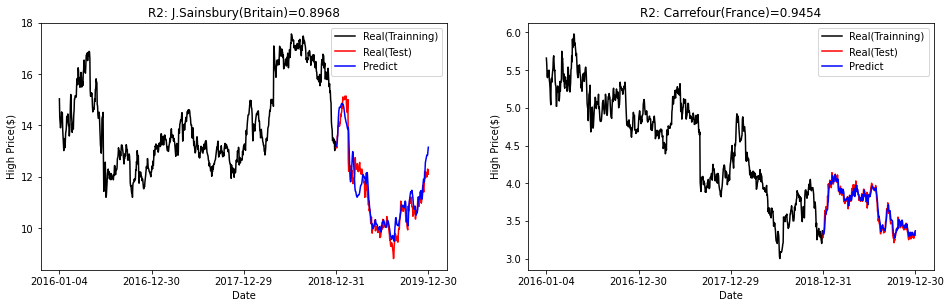

R2-2companies_average=0.9211060114124406

[Arguments]
num_company=2社 ['Kroger(USA)', 'George Weston(Canada)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 13s 224ms/step - loss: 0.3577
Epoch 2/50
22/22 [==============================] - 5s 220ms/step - loss: 0.1201
Epoch 3/50
22/22 [==============================] - 5s 223ms/step - loss: 0.0981
Epoch 4/50
22/22 [==============================] - 5s 220ms/step - loss: 0.0845
Epoch 5/50
22/22 [==============================] - 5s 224ms/step - loss: 0.0786
Epoch 6/50
22/22 [==============================] - 5s 220ms/step - loss: 0.0644
Epoch 7/50
22/22 [==============================] - 5s 223ms/step - loss: 0.0652
Epoch 8/50
22/22 [==============================] - 5s

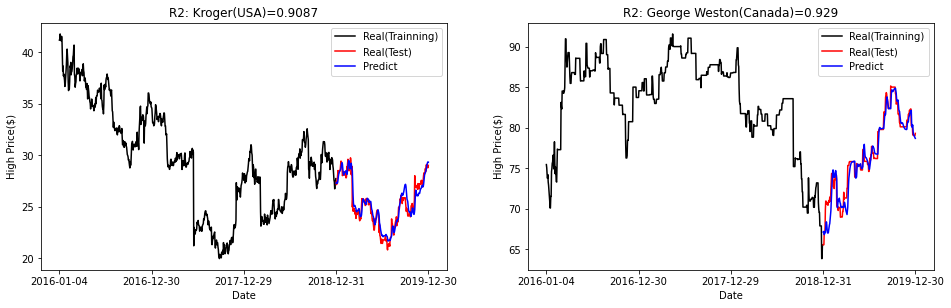

R2-2companies_average=0.9188458612066271

[Arguments]
num_company=2社 ['Carrefour(France)', 'Metro (Canada)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 13s 221ms/step - loss: 0.3644
Epoch 2/50
22/22 [==============================] - 5s 223ms/step - loss: 0.1292
Epoch 3/50
22/22 [==============================] - 5s 220ms/step - loss: 0.0864
Epoch 4/50
22/22 [==============================] - 5s 223ms/step - loss: 0.0798
Epoch 5/50
22/22 [==============================] - 5s 221ms/step - loss: 0.0787
Epoch 6/50
22/22 [==============================] - 5s 224ms/step - loss: 0.0752
Epoch 7/50
22/22 [==============================] - 5s 221ms/step - loss: 0.0730
Epoch 8/50
22/22 [==============================] - 5s 

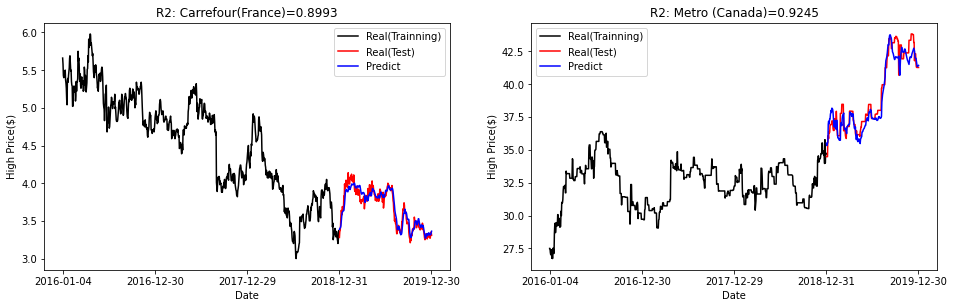

R2-2companies_average=0.9118900747925058

[Arguments]
num_company=2社 ['Walgreens Boots Alliance (USA)', 'Kroger(USA)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 12s 221ms/step - loss: 0.3677
Epoch 2/50
22/22 [==============================] - 5s 221ms/step - loss: 0.1809
Epoch 3/50
22/22 [==============================] - 5s 221ms/step - loss: 0.1589
Epoch 4/50
22/22 [==============================] - 5s 218ms/step - loss: 0.1453
Epoch 5/50
22/22 [==============================] - 5s 220ms/step - loss: 0.1211
Epoch 6/50
22/22 [==============================] - 5s 222ms/step - loss: 0.1126
Epoch 7/50
22/22 [==============================] - 5s 221ms/step - loss: 0.0943
Epoch 8/50
22/22 [===========================

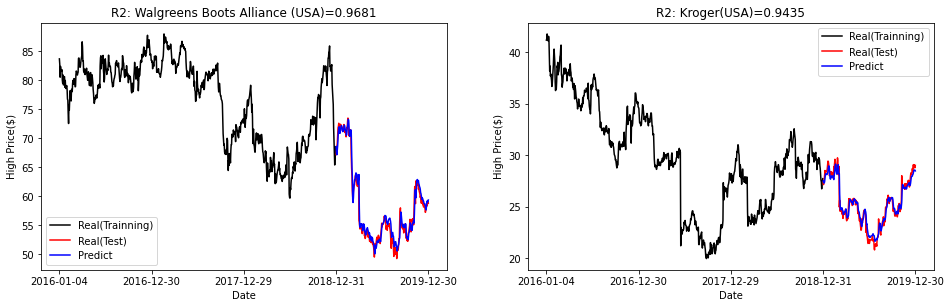

R2-2companies_average=0.9558016377895233

[Arguments]
num_company=2社 ['Metro (Canada)', 'Kroger(USA)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 13s 230ms/step - loss: 0.5001
Epoch 2/50
22/22 [==============================] - 5s 226ms/step - loss: 0.2205
Epoch 3/50
22/22 [==============================] - 5s 223ms/step - loss: 0.2052
Epoch 4/50
22/22 [==============================] - 5s 225ms/step - loss: 0.1808
Epoch 5/50
22/22 [==============================] - 5s 227ms/step - loss: 0.1527
Epoch 6/50
22/22 [==============================] - 5s 225ms/step - loss: 0.1555
Epoch 7/50
22/22 [==============================] - 5s 224ms/step - loss: 0.1449
Epoch 8/50
22/22 [==============================] - 5s 223ms/

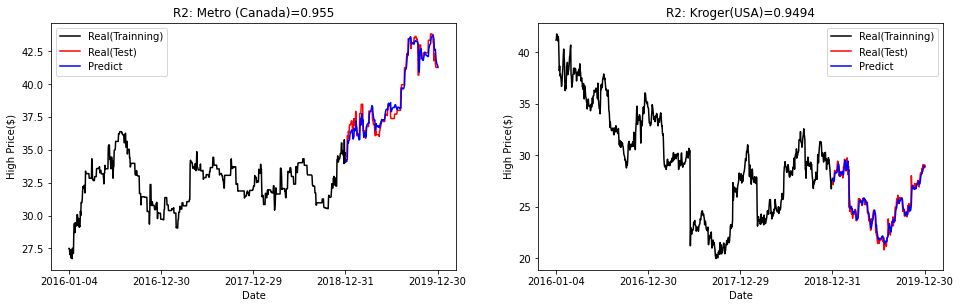

R2-2companies_average=0.9521913765401663

[Arguments]
num_company=2社 ['Seven & I Holdings (Japan)', 'Coop Group (Switzerland)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 12s 225ms/step - loss: 0.6201
Epoch 2/50
22/22 [==============================] - 5s 226ms/step - loss: 0.3678
Epoch 3/50
22/22 [==============================] - 5s 224ms/step - loss: 0.3507
Epoch 4/50
22/22 [==============================] - 5s 224ms/step - loss: 0.3097
Epoch 5/50
22/22 [==============================] - 5s 226ms/step - loss: 0.2764
Epoch 6/50
22/22 [==============================] - 5s 227ms/step - loss: 0.2207
Epoch 7/50
22/22 [==============================] - 5s 223ms/step - loss: 0.2285
Epoch 8/50
22/22 [==================

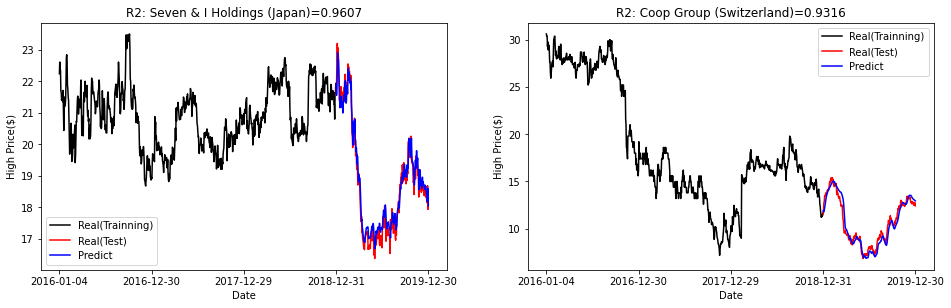

R2-2companies_average=0.94613415755247

[Arguments]
num_company=2社 ['Metro (Canada)', 'J.Sainsbury(Britain)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 12s 223ms/step - loss: 0.4735
Epoch 2/50
22/22 [==============================] - 5s 225ms/step - loss: 0.2190
Epoch 3/50
22/22 [==============================] - 5s 223ms/step - loss: 0.1925
Epoch 4/50
22/22 [==============================] - 5s 223ms/step - loss: 0.1468
Epoch 5/50
22/22 [==============================] - 5s 227ms/step - loss: 0.1491
Epoch 6/50
22/22 [==============================] - 5s 225ms/step - loss: 0.1329
Epoch 7/50
22/22 [==============================] - 5s 224ms/step - loss: 0.1389
Epoch 8/50
22/22 [==============================] - 5s

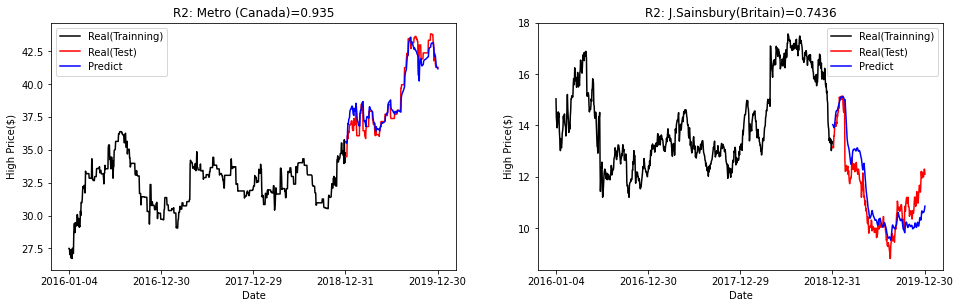

R2-2companies_average=0.8393053590075545

[Arguments]
num_company=2社 ['Tesco(Britain)', 'Metro (Canada)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(2, 754, 1), test_data=(2, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 2), y_trains=(1388,)
y_trains2=(2, 694)
1/2
Epoch 1/50
22/22 [==============================] - 13s 228ms/step - loss: 0.4666
Epoch 2/50
22/22 [==============================] - 5s 226ms/step - loss: 0.1151
Epoch 3/50
22/22 [==============================] - 5s 229ms/step - loss: 0.1042
Epoch 4/50
22/22 [==============================] - 5s 226ms/step - loss: 0.0884
Epoch 5/50
22/22 [==============================] - 5s 225ms/step - loss: 0.0878
Epoch 6/50
22/22 [==============================] - 5s 224ms/step - loss: 0.0754
Epoch 7/50
22/22 [==============================] - 5s 225ms/step - loss: 0.0682
Epoch 8/50
22/22 [==============================] - 5s 225

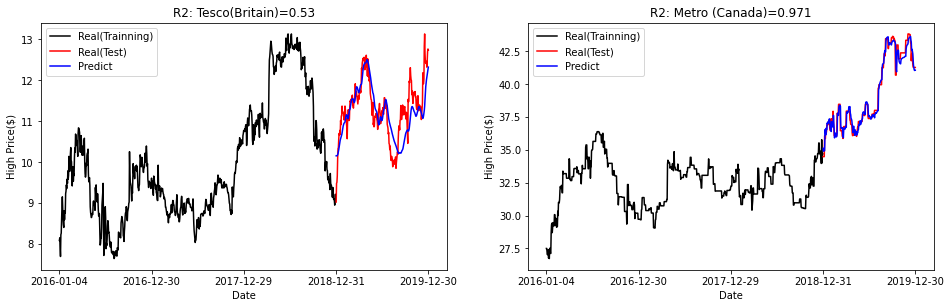

R2-2companies_average=0.7504613704681675



In [ ]:
# time_step=60, epochs=50, units=100
for i in range(10):
  all_in_all(all_data, num_company=2, input_num=[2], output_category=['High'], output_num=[2], outputs_company=2,
           train_size=754, time_step=60, epochs=50, units=100)

1回目
[Arguments]
num_company=3社 ['J.Sainsbury(Britain)', 'Carrefour(France)', 'George Weston(Canada)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 11s 209ms/step - loss: 0.3980
Epoch 2/50
22/22 [==============================] - 5s 205ms/step - loss: 0.1454
Epoch 3/50
22/22 [==============================] - 4s 201ms/step - loss: 0.1182
Epoch 4/50
22/22 [==============================] - 4s 204ms/step - loss: 0.0941
Epoch 5/50
22/22 [==============================] - 4s 202ms/step - loss: 0.0943
Epoch 6/50
22/22 [==============================] - 4s 203ms/step - loss: 0.0802
Epoch 7/50
22/22 [==============================] - 5s 208ms/step - loss: 0.0812
Epoch 8/50
22/22 [==============================] - 5s 209ms/s

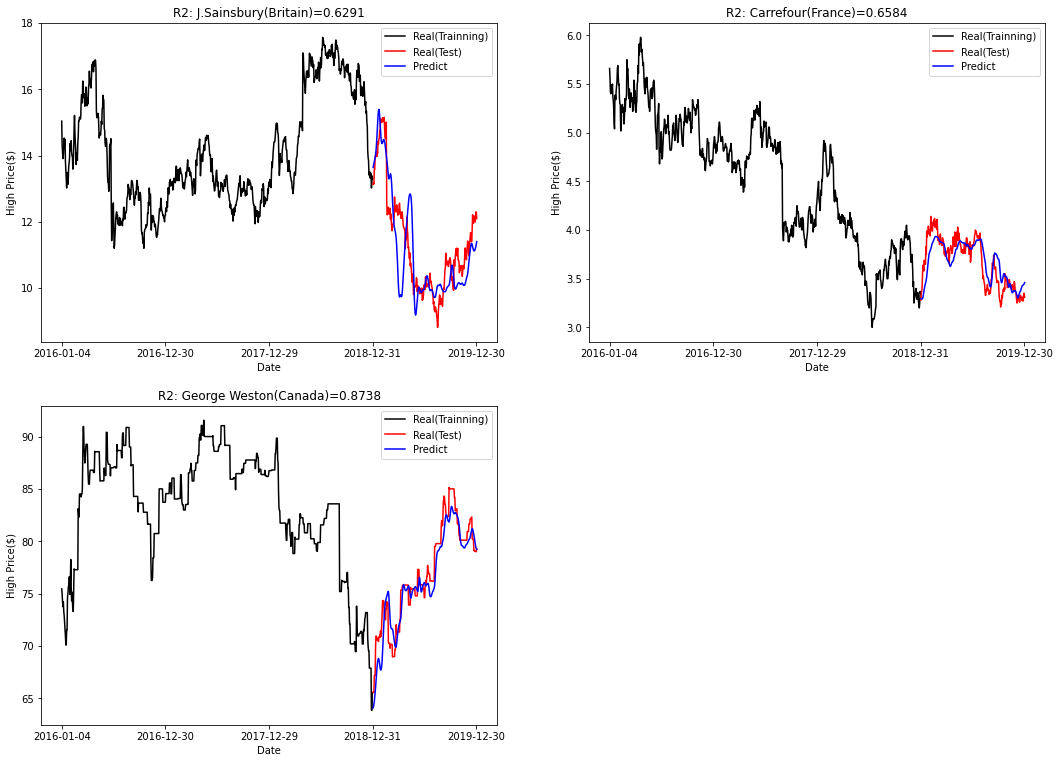

R2-3companies_average=0.7204

2回目
[Arguments]
num_company=3社 ['Carrefour(France)', 'Kroger(USA)', 'Royal Ahold Delhaize(Netherlands)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 11s 214ms/step - loss: 0.3819
Epoch 2/50
22/22 [==============================] - 5s 210ms/step - loss: 0.1083
Epoch 3/50
22/22 [==============================] - 5s 207ms/step - loss: 0.0844
Epoch 4/50
22/22 [==============================] - 5s 211ms/step - loss: 0.1033
Epoch 5/50
22/22 [==============================] - 5s 209ms/step - loss: 0.0887
Epoch 6/50
22/22 [==============================] - 5s 211ms/step - loss: 0.0689
Epoch 7/50
22/22 [==============================] - 5s 211ms/step - loss: 0.0786
Epoch 8/50
22/22 [===========

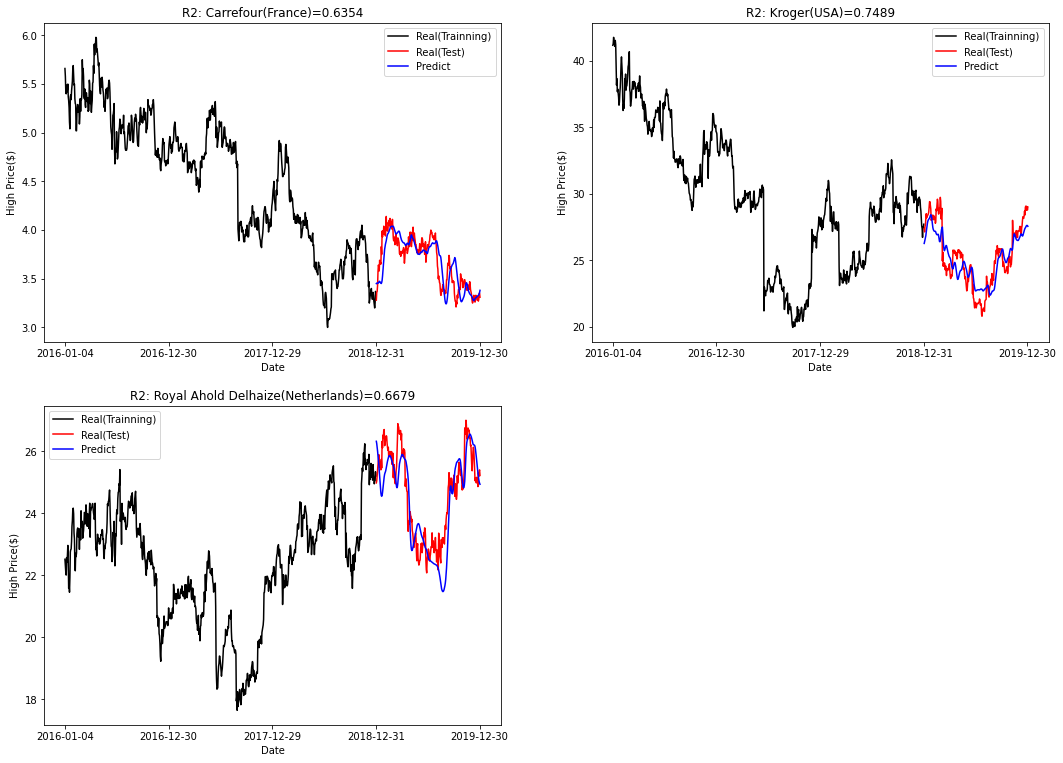

R2-3companies_average=0.6841

3回目
[Arguments]
num_company=3社 ['Kroger(USA)', 'Walgreens Boots Alliance (USA)', 'Carrefour(France)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 11s 210ms/step - loss: 0.3435
Epoch 2/50
22/22 [==============================] - 5s 213ms/step - loss: 0.1029
Epoch 3/50
22/22 [==============================] - 5s 209ms/step - loss: 0.0841
Epoch 4/50
22/22 [==============================] - 5s 211ms/step - loss: 0.0848
Epoch 5/50
22/22 [==============================] - 5s 211ms/step - loss: 0.0683
Epoch 6/50
22/22 [==============================] - 5s 212ms/step - loss: 0.0679
Epoch 7/50
22/22 [==============================] - 5s 210ms/step - loss: 0.0522
Epoch 8/50
22/22 [==============

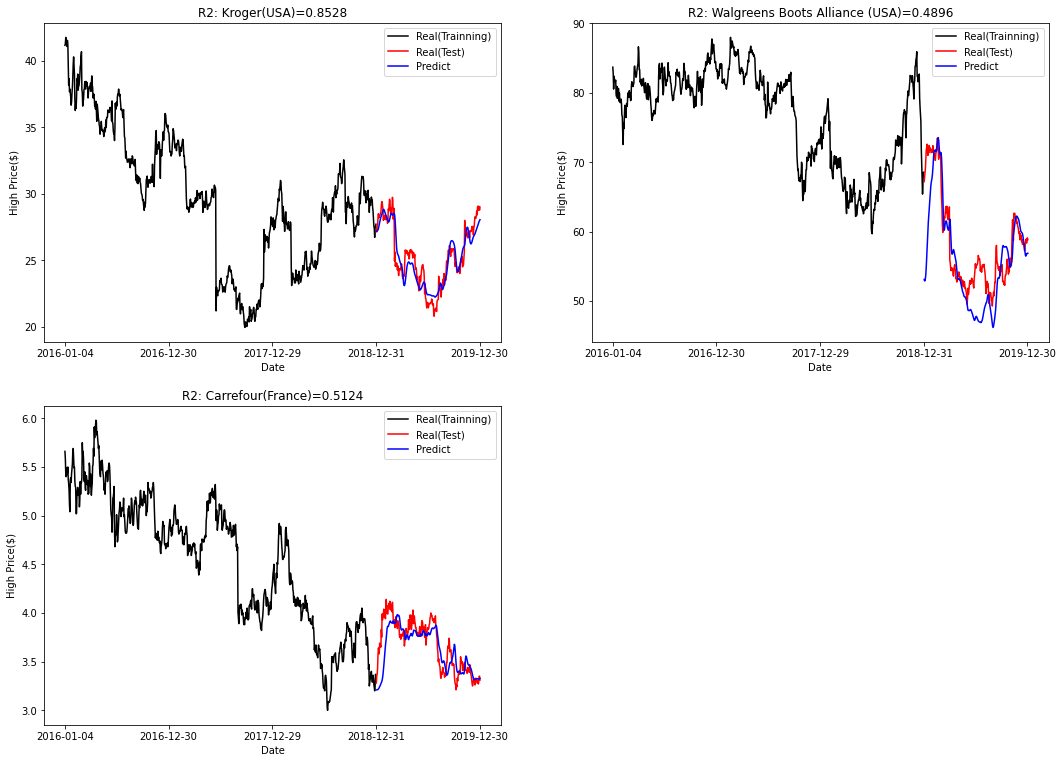

R2-3companies_average=0.6183

4回目
[Arguments]
num_company=3社 ['Seven & I Holdings (Japan)', 'Kroger(USA)', 'J.Sainsbury(Britain)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(3, 754, 1), test_data=(3, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 3), y_trains=(2082,)
y_trains2=(3, 694)
1/3
Epoch 1/50
22/22 [==============================] - 13s 216ms/step - loss: 0.6603
Epoch 2/50
22/22 [==============================] - 5s 213ms/step - loss: 0.3895
Epoch 3/50
22/22 [==============================] - 5s 209ms/step - loss: 0.3189
Epoch 4/50
22/22 [==============================] - 5s 208ms/step - loss: 0.3169
Epoch 5/50
22/22 [==============================] - 5s 211ms/step - loss: 0.2931
Epoch 6/50
22/22 [==============================] - 5s 210ms/step - loss: 0.2701
Epoch 7/50
22/22 [==============================] - 5s 214ms/step - loss: 0.2007
Epoch 8/50
22/22 [===============

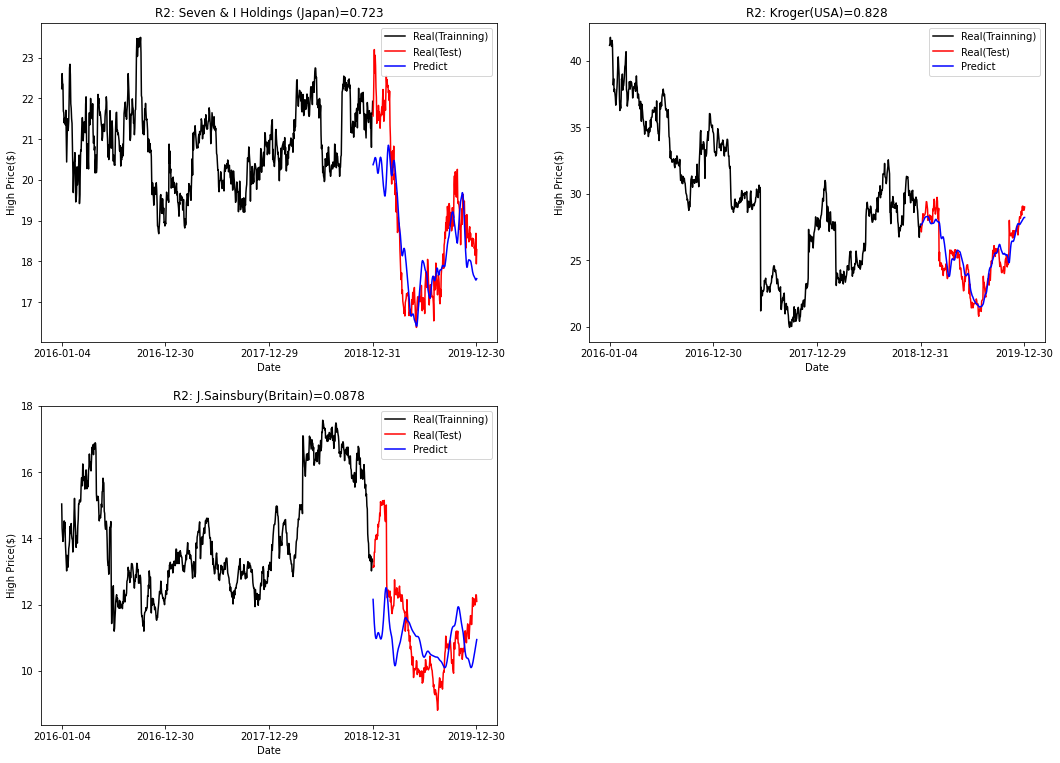

R2-3companies_average=0.5463



In [8]:
# time_step=60, epochs=50, units=100
for i in range(4):
  print(f"{i+1}回目")
  all_in_all(all_data, num_company=3, input_num=[2], output_category=['High'], output_num=[2], outputs_company=3,
           train_size=754, time_step=60, epochs=50, units=100)

1周目
[Arguments]
num_company=4社 ['Coop Group (Switzerland)', 'Metro (Canada)', 'J.Sainsbury(Britain)', 'George Weston(Canada)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 11s 185ms/step - loss: 0.3707
Epoch 2/50
22/22 [==============================] - 4s 184ms/step - loss: 0.0569
Epoch 3/50
22/22 [==============================] - 4s 184ms/step - loss: 0.0468
Epoch 4/50
22/22 [==============================] - 4s 183ms/step - loss: 0.0411
Epoch 5/50
22/22 [==============================] - 4s 184ms/step - loss: 0.0418
Epoch 6/50
22/22 [==============================] - 4s 185ms/step - loss: 0.0400
Epoch 7/50
22/22 [==============================] - 4s 183ms/step - loss: 0.0327
Epoch 8/50
22/22 [===================

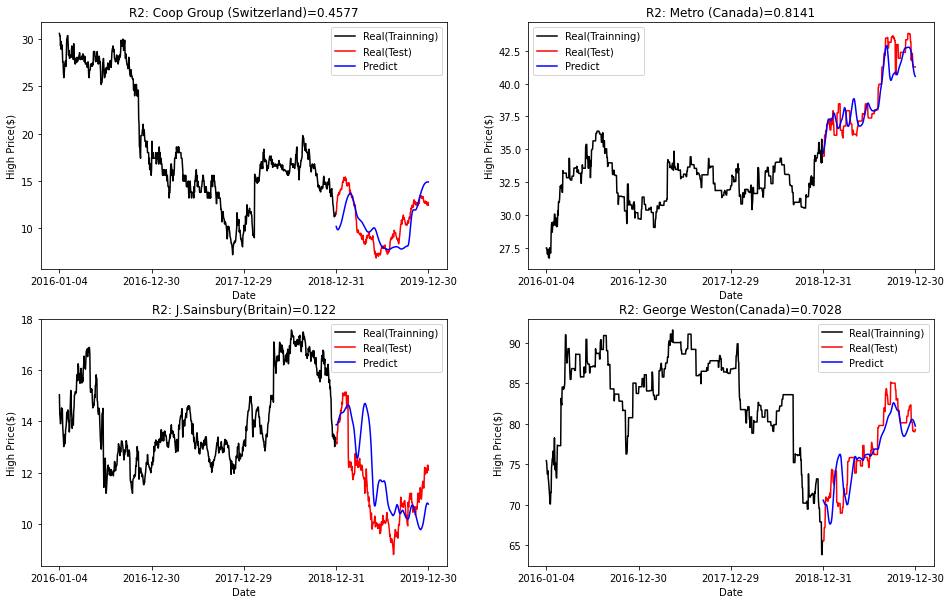

R2-4companies_average=0.5242

2周目
[Arguments]
num_company=4社 ['Tesco(Britain)', 'Royal Ahold Delhaize(Netherlands)', 'AEON(Japan)', 'George Weston(Canada)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 13s 190ms/step - loss: 0.4281
Epoch 2/50
22/22 [==============================] - 4s 189ms/step - loss: 0.1156
Epoch 3/50
22/22 [==============================] - 4s 188ms/step - loss: 0.0848
Epoch 4/50
22/22 [==============================] - 4s 186ms/step - loss: 0.0871
Epoch 5/50
22/22 [==============================] - 4s 186ms/step - loss: 0.0743
Epoch 6/50
22/22 [==============================] - 4s 187ms/step - loss: 0.0748
Epoch 7/50
22/22 [==============================] - 4s 186ms/step - loss: 0.0668
Epoch 8

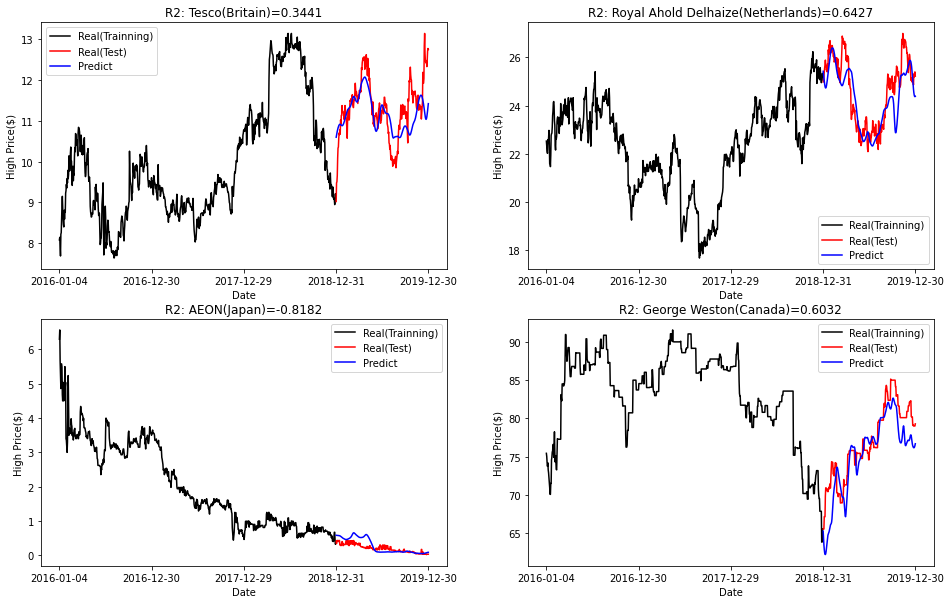

R2-4companies_average=0.193

3周目
[Arguments]
num_company=4社 ['Kroger(USA)', 'Walgreens Boots Alliance (USA)', 'Carrefour(France)', 'J.Sainsbury(Britain)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 12s 189ms/step - loss: 0.4201
Epoch 2/50
22/22 [==============================] - 4s 188ms/step - loss: 0.1142
Epoch 3/50
22/22 [==============================] - 4s 189ms/step - loss: 0.0899
Epoch 4/50
22/22 [==============================] - 4s 187ms/step - loss: 0.0808
Epoch 5/50
22/22 [==============================] - 4s 189ms/step - loss: 0.0723
Epoch 6/50
22/22 [==============================] - 4s 186ms/step - loss: 0.0631
Epoch 7/50
22/22 [==============================] - 4s 188ms/step - loss: 0.0559
Epoch 8/5

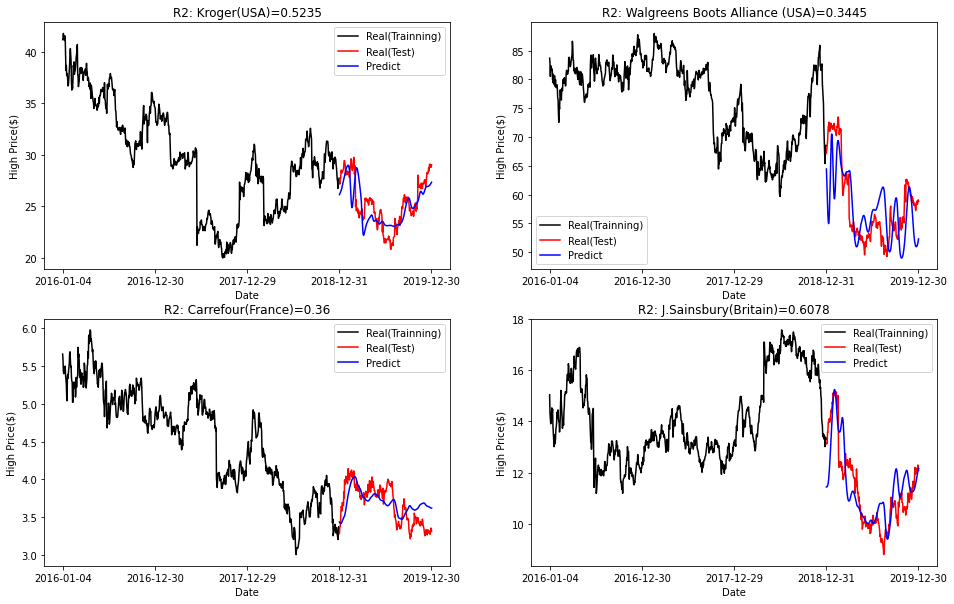

R2-4companies_average=0.4589

4周目
[Arguments]
num_company=4社 ['Tesco(Britain)', 'Coop Group (Switzerland)', 'George Weston(Canada)', 'AEON(Japan)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 10s 186ms/step - loss: 0.4738
Epoch 2/50
22/22 [==============================] - 4s 186ms/step - loss: 0.1044
Epoch 3/50
22/22 [==============================] - 4s 184ms/step - loss: 0.0855
Epoch 4/50
22/22 [==============================] - 4s 186ms/step - loss: 0.0872
Epoch 5/50
22/22 [==============================] - 4s 186ms/step - loss: 0.0735
Epoch 6/50
22/22 [==============================] - 4s 186ms/step - loss: 0.0818
Epoch 7/50
22/22 [==============================] - 4s 184ms/step - loss: 0.0659
Epoch 8/50
22/22

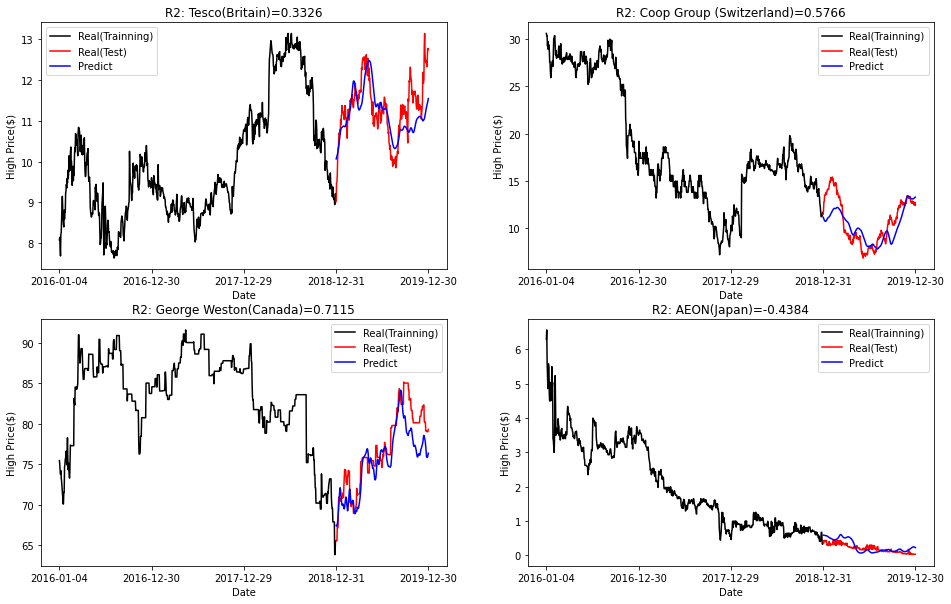

R2-4companies_average=0.2956

5周目
[Arguments]
num_company=4社 ['Seven & I Holdings (Japan)', 'Tesco(Britain)', 'George Weston(Canada)', 'Royal Ahold Delhaize(Netherlands)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 14s 192ms/step - loss: 0.6822
Epoch 2/50
22/22 [==============================] - 4s 187ms/step - loss: 0.3488
Epoch 3/50
22/22 [==============================] - 4s 194ms/step - loss: 0.3195
Epoch 4/50
22/22 [==============================] - 4s 193ms/step - loss: 0.2570
Epoch 5/50
22/22 [==============================] - 4s 188ms/step - loss: 0.2586
Epoch 6/50
22/22 [==============================] - 4s 189ms/step - loss: 0.2490
Epoch 7/50
22/22 [==============================] - 4s 188ms/step - loss:

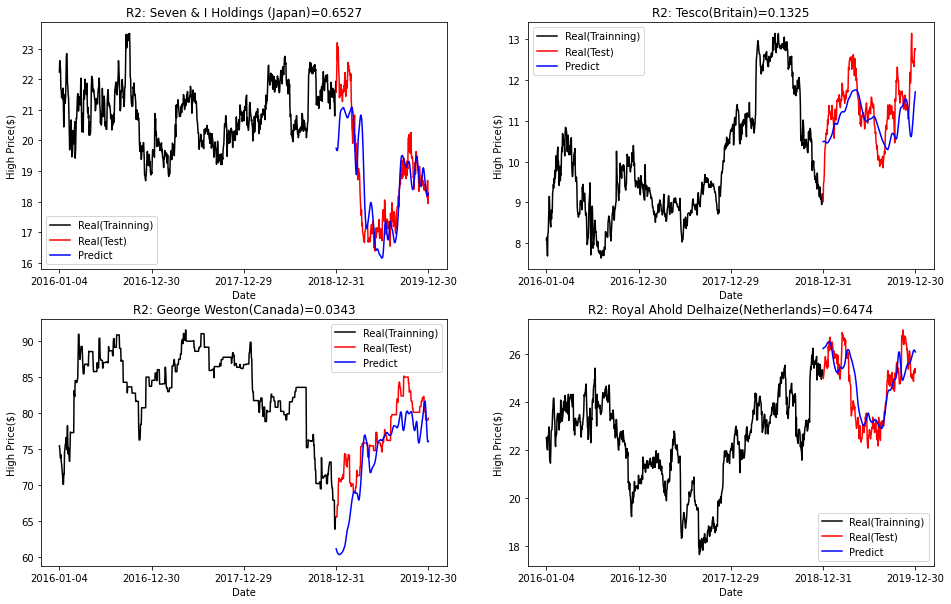

R2-4companies_average=0.3667

6周目
[Arguments]
num_company=4社 ['George Weston(Canada)', 'Kroger(USA)', 'Metro (Canada)', 'Carrefour(France)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 15s 211ms/step - loss: 0.4503
Epoch 2/50
22/22 [==============================] - 5s 211ms/step - loss: 0.1565
Epoch 3/50
22/22 [==============================] - 5s 214ms/step - loss: 0.1147
Epoch 4/50
22/22 [==============================] - 5s 206ms/step - loss: 0.1037
Epoch 5/50
22/22 [==============================] - 5s 214ms/step - loss: 0.1135
Epoch 6/50
22/22 [==============================] - 5s 209ms/step - loss: 0.0972
Epoch 7/50
22/22 [==============================] - 5s 211ms/step - loss: 0.0774
Epoch 8/50
22/22 [=====

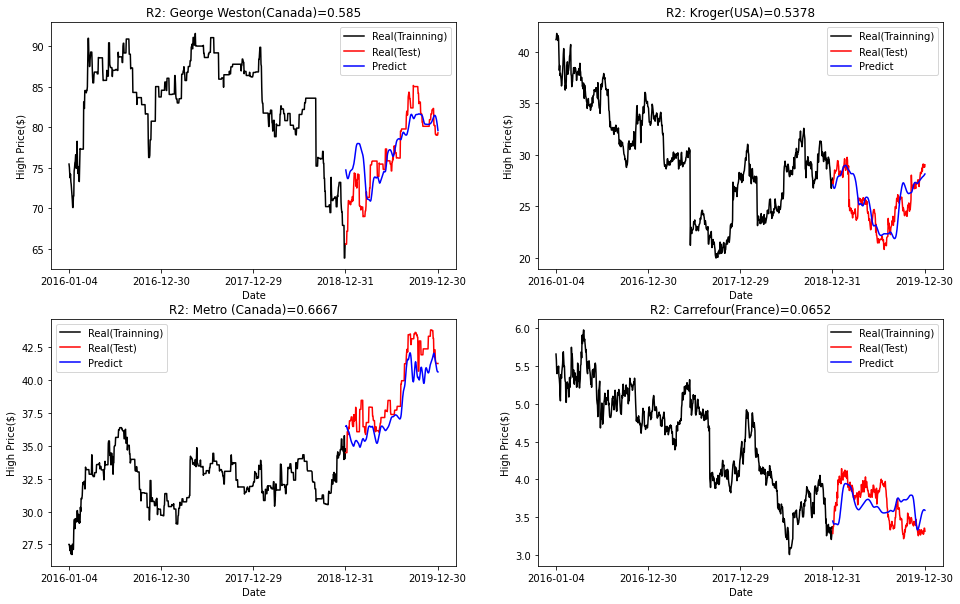

R2-4companies_average=0.4637

7周目
[Arguments]
num_company=4社 ['Metro (Canada)', 'George Weston(Canada)', 'Kroger(USA)', 'Seven & I Holdings (Japan)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 12s 210ms/step - loss: 0.4000
Epoch 2/50
22/22 [==============================] - 5s 207ms/step - loss: 0.1738
Epoch 3/50
22/22 [==============================] - 5s 213ms/step - loss: 0.1482
Epoch 4/50
22/22 [==============================] - 5s 206ms/step - loss: 0.1377
Epoch 5/50
22/22 [==============================] - 5s 211ms/step - loss: 0.1393
Epoch 6/50
22/22 [==============================] - 5s 206ms/step - loss: 0.1285
Epoch 7/50
22/22 [==============================] - 5s 208ms/step - loss: 0.1287
Epoch 8/50
22/

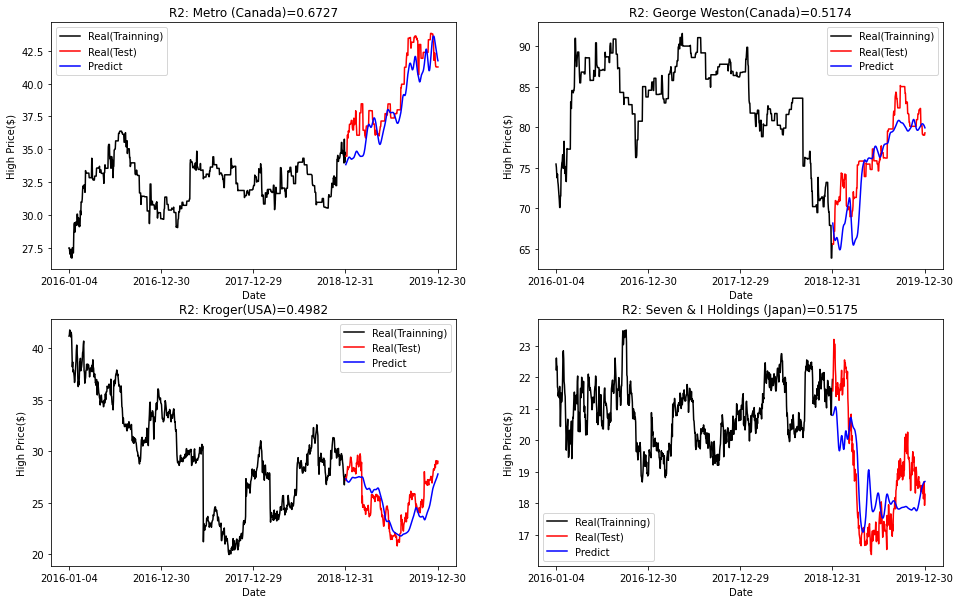

R2-4companies_average=0.5515

8周目
[Arguments]
num_company=4社 ['Royal Ahold Delhaize(Netherlands)', 'Coop Group (Switzerland)', 'Metro (Canada)', 'George Weston(Canada)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 14s 212ms/step - loss: 0.4578
Epoch 2/50
22/22 [==============================] - 5s 211ms/step - loss: 0.1524
Epoch 3/50
22/22 [==============================] - 5s 210ms/step - loss: 0.1123
Epoch 4/50
22/22 [==============================] - 5s 214ms/step - loss: 0.0979
Epoch 5/50
22/22 [==============================] - 5s 211ms/step - loss: 0.0952
Epoch 6/50
22/22 [==============================] - 5s 204ms/step - loss: 0.0871
Epoch 7/50
22/22 [==============================] - 4s 193ms/step - loss: 0

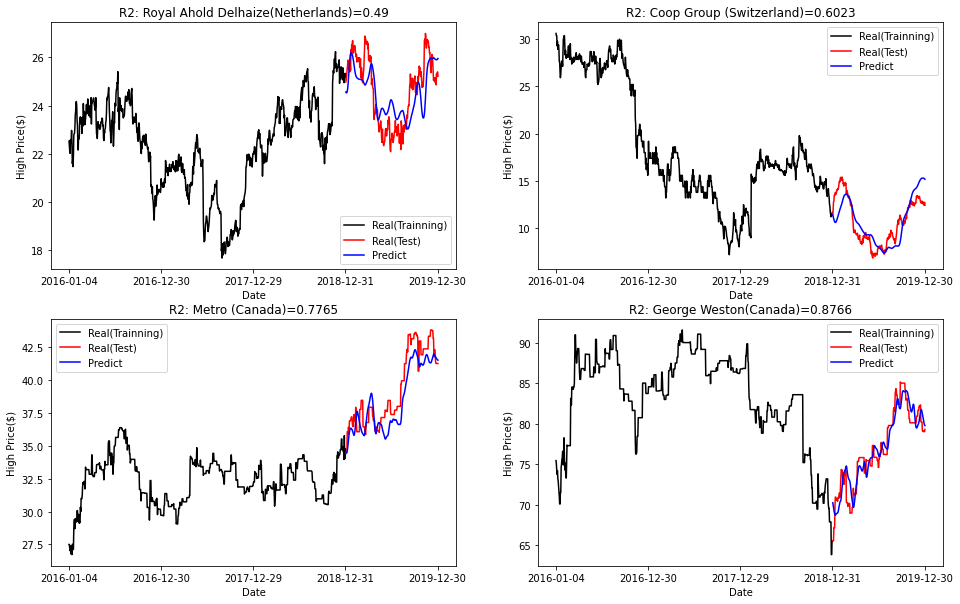

R2-4companies_average=0.6864

9周目
[Arguments]
num_company=4社 ['Royal Ahold Delhaize(Netherlands)', 'Tesco(Britain)', 'J.Sainsbury(Britain)', 'Seven & I Holdings (Japan)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 12s 192ms/step - loss: 0.6185
Epoch 2/50
22/22 [==============================] - 4s 194ms/step - loss: 0.2254
Epoch 3/50
22/22 [==============================] - 4s 191ms/step - loss: 0.1371
Epoch 4/50
22/22 [==============================] - 4s 191ms/step - loss: 0.1080
Epoch 5/50
22/22 [==============================] - 4s 192ms/step - loss: 0.1089
Epoch 6/50
22/22 [==============================] - 4s 190ms/step - loss: 0.0841
Epoch 7/50
22/22 [==============================] - 4s 191ms/step - loss: 

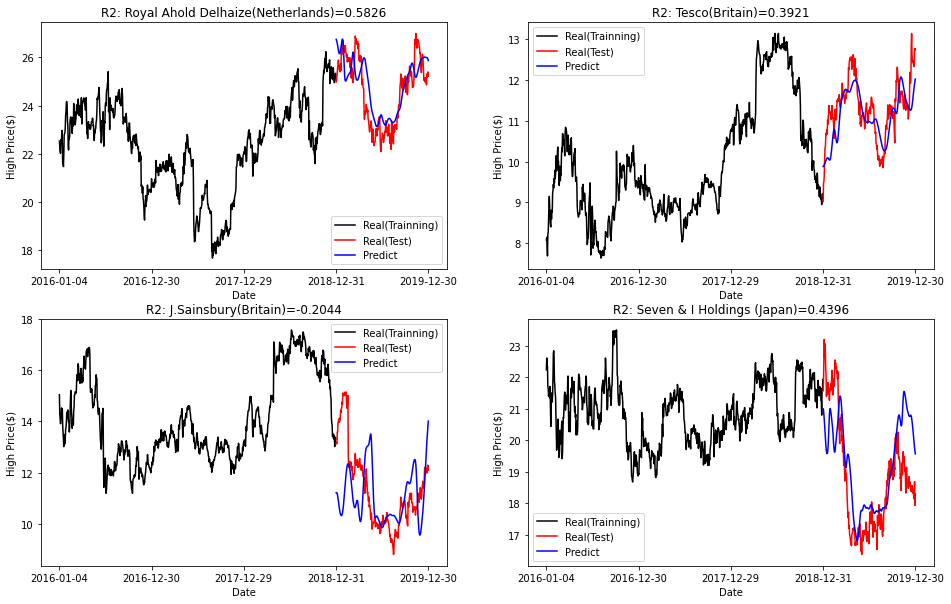

R2-4companies_average=0.3025

10周目
[Arguments]
num_company=4社 ['George Weston(Canada)', 'Seven & I Holdings (Japan)', 'Walgreens Boots Alliance (USA)', 'J.Sainsbury(Britain)']
input_item=[2], outout_item=[2], output_category=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100

~~Make models~~
train_data=(4, 754, 1), test_data=(4, 252, 1)
SECTOR2
SECTOR2-2
X_train=(694, 60, 4), y_trains=(2776,)
y_trains2=(4, 694)
1/4
Epoch 1/50
22/22 [==============================] - 12s 212ms/step - loss: 0.3751
Epoch 2/50
22/22 [==============================] - 5s 212ms/step - loss: 0.1331
Epoch 3/50
22/22 [==============================] - 5s 212ms/step - loss: 0.1175
Epoch 4/50
22/22 [==============================] - 5s 209ms/step - loss: 0.1104
Epoch 5/50
22/22 [==============================] - 5s 209ms/step - loss: 0.0885
Epoch 6/50
22/22 [==============================] - 5s 210ms/step - loss: 0.0845
Epoch 7/50
22/22 [==============================] - 5s 215ms/step - l

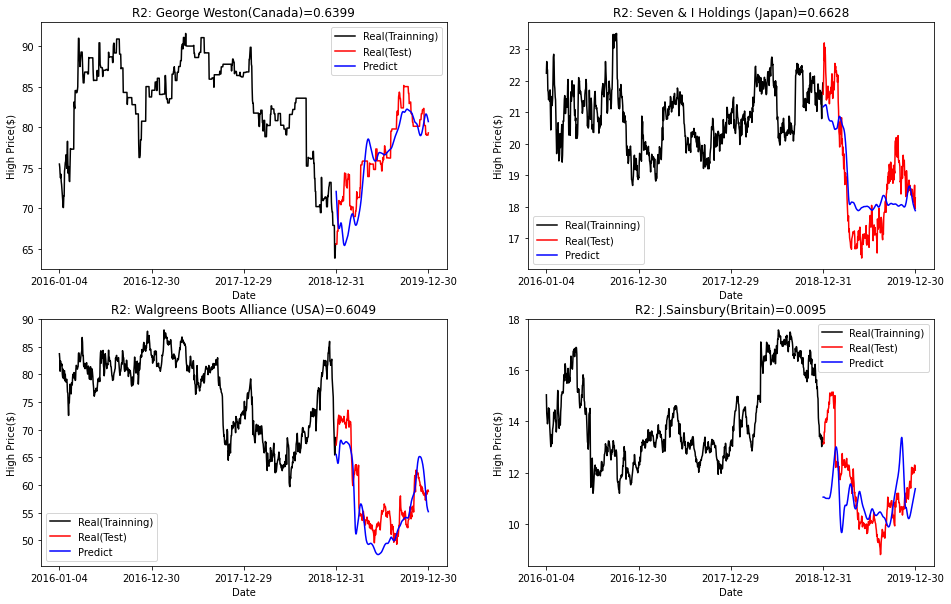

R2-4companies_average=0.4793



In [10]:
# time_step=60, epochs=50, units=100
for i in range(10):
  print(f"{i+1}周目")
  all_in_all(all_data, num_company=4, input_num=[2], output_category=['High'], output_num=[2], outputs_company=4,
           train_size=754, time_step=60, epochs=50, units=100)

In [17]:
# time_step=60, epochs=50, units=100
for i in range(10):
  print(f"{i+1}周目")
  all_in_all(all_data, num_company=5, input_num=[2], output_category=['High'], output_num=[2], outputs_company=5,
           train_size=754, time_step=60, epochs=50, units=100)

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# time_step=60, epochs=50, units=100
for i in range(10):
  print(f"{i+1}周目")
  all_in_all(all_data, num_company=6, input_num=[2], output_category=['High'], output_num=[2], outputs_company=6,
           train_size=754, time_step=60, epochs=50, units=100)

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# time_step=60, epochs=50, units=100
for i in range(10):
  print(f"{i+1}周目")
  all_in_all(all_data, num_company=7, input_num=[2], output_category=['High'], output_num=[2], outputs_company=7,
           train_size=754, time_step=60, epochs=50, units=100)

Output hidden; open in https://colab.research.google.com to view.